In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate

# set a custom figure style (this is optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['font.family'] = 'Myriad Pro'

In [2]:
data = pd.read_csv('GRR997synthinput.csv', delimiter=',', names=['lambda', 'a_axis', 'b_axis', 'c_axis'])
data

,lambda,a_axis,b_axis,c_axis
0,1100.19,0.022589,0.056694,0.023680
1,1101.15,0.029813,-0.010129,0.073400
2,1102.12,0.042242,0.039765,0.114789
3,1103.08,0.152352,0.118840,0.130725
4,1104.05,0.213039,0.153203,0.148731
...,...,...,...,...
3003,3995.78,-0.000334,-0.000040,0.001882
3004,3996.75,0.000137,-0.000497,0.000862
3005,3997.71,0.000000,0.000000,0.000000
3006,3998.68,0.000000,0.000000,0.000000


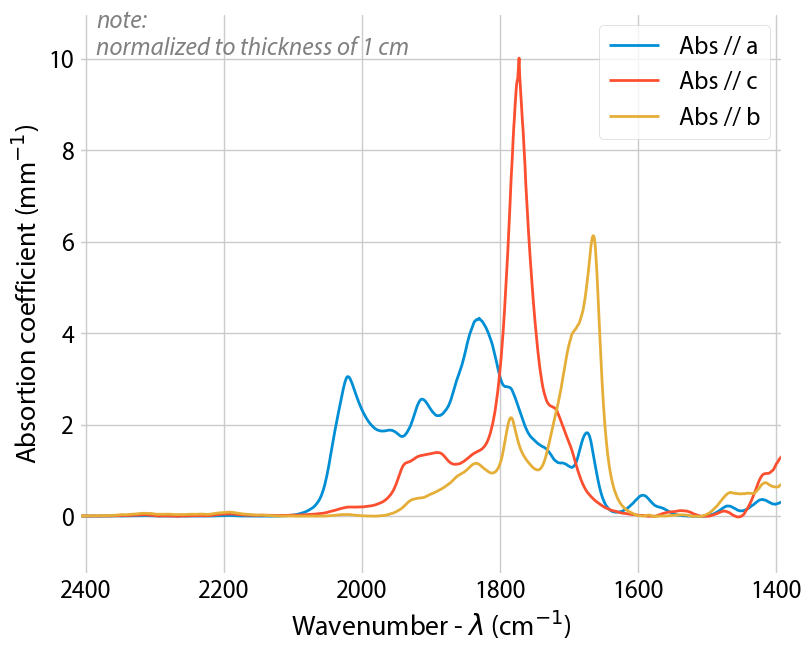

In [3]:
# make figure
fig, ax = plt.subplots(figsize=(8, 8*0.8), constrained_layout=True)

ax.plot(data['lambda'], data['a_axis'], linewidth=2, label=r'Abs // a')
ax.plot(data['lambda'], data['c_axis'], linewidth=2, label=r'Abs // c')
ax.plot(data['lambda'], data['b_axis'], linewidth=2, label=r'Abs // b')
ax.set_xlabel('Wavenumber - $\lambda$ (cm$^{-1}$)', fontsize=20)
ax.set_ylabel('Absortion coefficient (mm$^{-1}$)', fontsize=20)

# invert x axis
plt.gca().invert_xaxis()

# set custom x- and y-axis limits
ax.set_xlim(left=2410, right=1390)
ax.set_ylim(top=11)

# annotate
ax.text(x=2385, y=10.1, s='note:\nnormalized to thickness of 1 cm', fontsize=18, color='gray', fontstyle='italic')

ax.legend(loc='best', fontsize=18)
ax.tick_params(axis='both', labelsize=18)

The unpolarized absorbance according to Libowitzky and Rossman (1996) is

$$
A_{unpol} = -log_{10} \left( \frac{10^{-A_a} + 10^{-A_c}}{2} \right)
$$

> Eq. 11 in Withers (2013)

In [4]:
data['A_unpol'] = - np.log10((10**-data['a_axis'] + 10**-data['c_axis']) / 2)
data

,lambda,a_axis,b_axis,c_axis,A_unpol
0,1100.19,0.022589,0.056694,0.023680,0.023134
1,1101.15,0.029813,-0.010129,0.073400,0.051060
2,1102.12,0.042242,0.039765,0.114789,0.077003
3,1103.08,0.152352,0.118840,0.130725,0.141404
4,1104.05,0.213039,0.153203,0.148731,0.179696
...,...,...,...,...,...
3003,3995.78,-0.000334,-0.000040,0.001882,0.000773
3004,3996.75,0.000137,-0.000497,0.000862,0.000500
3005,3997.71,0.000000,0.000000,0.000000,-0.000000
3006,3998.68,0.000000,0.000000,0.000000,-0.000000


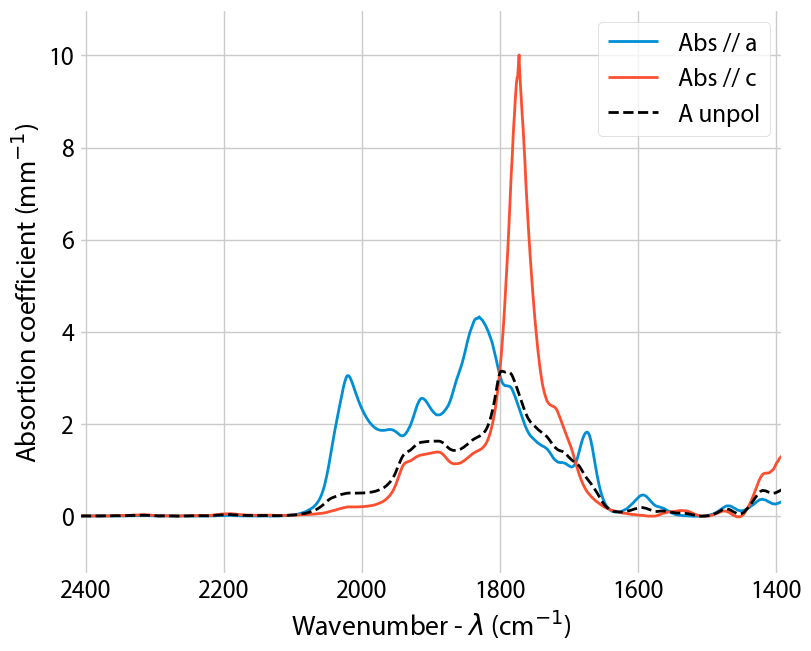

In [5]:
# make figure
fig, ax = plt.subplots(figsize=(8, 8*0.8), constrained_layout=True)

ax.plot(data['lambda'], data['a_axis'], linewidth=2, label=r'Abs // a')
ax.plot(data['lambda'], data['c_axis'], linewidth=2, label=r'Abs // c')
ax.plot(data['lambda'], data['A_unpol'], '--', color='black', linewidth=2, label=r'A unpol')
ax.set_xlabel('Wavenumber - $\lambda$ (cm$^{-1}$)', fontsize=20)
ax.set_ylabel('Absortion coefficient (mm$^{-1}$)', fontsize=20)

# invert x axis
plt.gca().invert_xaxis()

# set custom x- and y-axis limits
ax.set_xlim(left=2410, right=1390)
ax.set_ylim(top=11)

ax.legend(loc='best', fontsize=18)
ax.tick_params(axis='both', labelsize=18)

The unpolarized absorbance according to Sambridge et al. (2008) is

$$
A_{unpol} = \frac{1}{2\pi} \int_{0}^{2\pi} A(\theta) d\theta
$$

where $A(\theta)$

$$
A(\theta) = -log_{10} \left( 10^{-A_a} cos^2\theta + 10^{-A_c} sin^2\theta  \right)
$$

> Eqs. 12 and 13 in Withers 2013 

In [6]:
# define the function to integrate
def f(theta, Aa, Ac):
    return -np.log10(10**-Aa * np.cos(theta)**2 + 10**-Ac * np.sin(theta)**2)

In [7]:
# TEST
# get some a xis and c axis values for a especific lambda value (e.g. 1800.22 which is at index postion 726)
Aa = data.loc[726, 'a_axis']
Ac = data.loc[726, 'c_axis']

# fixed_quad compute a definite integral using fixed-order Gaussian quadrature. See https://docs.scipy.org/doc/scipy/reference/integrate.html
result, error = integrate.fixed_quad(f, 0, 2*np.pi, n=20, args=(Aa, Ac))

print("Result:", result / (2*np.pi))
print("Error:", error)

Result: 3.099371342523781
Error: None


In [8]:
# define the function to apply to the dataFrame row by row
def sambridge(data):
    result, _ = integrate.fixed_quad(f, 0, 2*np.pi, n=20, args=(data['a_axis'], data['c_axis']))
    return result / (2*np.pi)

# applay the sambridge approach to each row and store the results in a new column
data['A_unpol2'] = data.apply(lambda data: sambridge(data), axis=1)

In [9]:
data

,lambda,a_axis,b_axis,c_axis,A_unpol,A_unpol2
0,1100.19,0.022589,0.056694,0.023680,0.023134,2.313463e-02
1,1101.15,0.029813,-0.010129,0.073400,0.051060,5.133317e-02
2,1102.12,0.042242,0.039765,0.114789,0.077003,7.775841e-02
3,1103.08,0.152352,0.118840,0.130725,0.141404,1.414712e-01
4,1104.05,0.213039,0.153203,0.148731,0.179696,1.802900e-01
...,...,...,...,...,...,...
3003,3995.78,-0.000334,-0.000040,0.001882,0.000773,7.733674e-04
3004,3996.75,0.000137,-0.000497,0.000862,0.000500,4.996474e-04
3005,3997.71,0.000000,0.000000,0.000000,-0.000000,1.050032e-17
3006,3998.68,0.000000,0.000000,0.000000,-0.000000,1.050032e-17


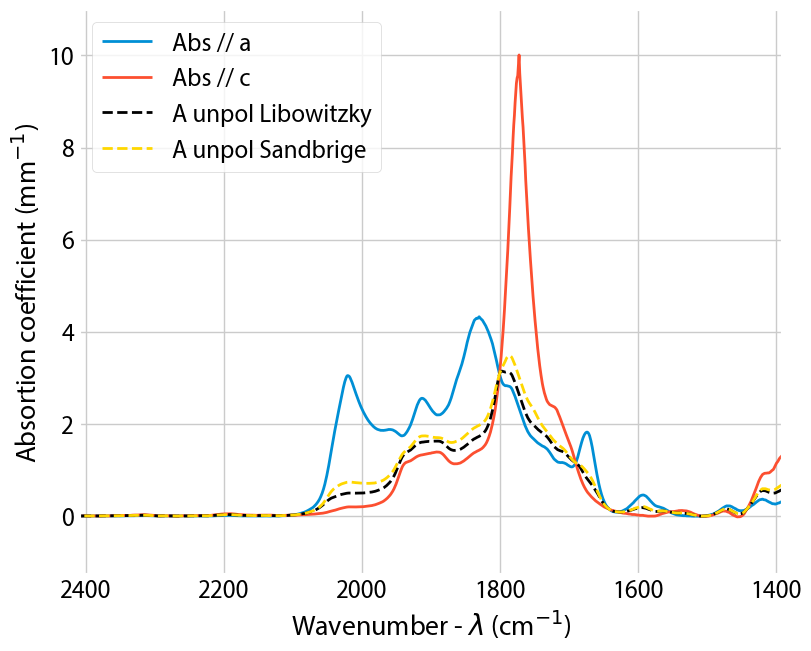

In [10]:
# make figure
fig, ax = plt.subplots(figsize=(8, 8*0.8), constrained_layout=True)

ax.plot(data['lambda'], data['a_axis'], linewidth=2, label=r'Abs // a')
ax.plot(data['lambda'], data['c_axis'], linewidth=2, label=r'Abs // c')
ax.plot(data['lambda'], data['A_unpol'], '--', color='black', linewidth=2, label=r'A unpol Libowitzky')
ax.plot(data['lambda'], data['A_unpol2'], '--', color='gold', linewidth=2, label=r'A unpol Sandbrige')
ax.set_xlabel('Wavenumber - $\lambda$ (cm$^{-1}$)', fontsize=20)
ax.set_ylabel('Absortion coefficient (mm$^{-1}$)', fontsize=20)

# invert x axis
plt.gca().invert_xaxis()

# set custom x- and y-axis limits
ax.set_xlim(left=2410, right=1390)
ax.set_ylim(top=11)

ax.legend(loc='best', fontsize=18)
ax.tick_params(axis='both', labelsize=18)